In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, rand
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from sklearn.ensemble import RandomForestClassifier as SKRandomForest, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
print("=== Credit Card Fraud Detection Project ===")
print("Day 3: Model Development and Training")
print("Advanced machine learning with both Spark ML and scikit-learn")

# ============================================================================
# 1. SPARK SESSION SETUP AND DATA LOADING
# ============================================================================
print("\n1. Setting up Spark Session for ML Development...")

# Create optimized Spark session for ML
spark = SparkSession.builder \
    .appName("FraudDetection_ModelDevelopment") \
    .config("spark.driver.memory", "6g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

# Load preprocessed data
try:
    df_features = spark.read.parquet("processed_data/features_engineered.parquet")
    print("✅ Loaded preprocessed features from parquet")
except:
    print("⚠️ Parquet not found, loading from CSV and recreating features...")
    # Fallback to recreate features if parquet doesn't exist
    df = spark.read.csv("creditcard_2023.csv", header=True, inferSchema=True)
    # Add basic feature engineering here if needed
    df_features = df  # Simplified for demo

print(f"Dataset loaded: {df_features.count():,} rows, {len(df_features.columns)} columns")


=== Credit Card Fraud Detection Project ===
Day 3: Model Development and Training
Advanced machine learning with both Spark ML and scikit-learn

1. Setting up Spark Session for ML Development...


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/30 08:34:39 WARN Utils: Your hostname, Howards-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.74.245.116 instead (on interface en0)
25/07/30 08:34:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/30 08:34:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.0.0
Spark UI: http://10.74.245.116:4040


✅ Loaded preprocessed features from parquet
Dataset loaded: 568,630 rows, 43 columns


In [7]:
# ============================================================================
# 2. DATA SPLITTING STRATEGY
# ============================================================================
print("\n2. Splitting Data for Training and Evaluation...")

# For fraud detection, we need stratified sampling to maintain class balance
class_distribution = df_features.groupBy("Class").count().collect()
for row in class_distribution:
    print(f"Class {row['Class']}: {row['count']:,} samples")

# Split data: 60% train, 20% validation, 20% test
# Add random columns for splitting
df_with_rand = df_features.withColumn("rand", rand(seed=42))

# Create Splits
train_data = df_with_rand.filter(col("rand") < 0.6).drop("rand")
val_data = df_with_rand.filter((col("rand") >= 0.6) & (col("rand") <= 0.8)).drop("rand")
test_data = df_with_rand.filter(col("rand") >= 0.8).drop("rand")

print(f"Training set: {train_data.count():,} samples")
print(f"Validation set: {val_data.count():,} samples")
print(f"Test set: {test_data.count():,} samples")


2. Splitting Data for Training and Evaluation...
Class 1: 284,315 samples
Class 0: 284,315 samples
Training set: 341,751 samples
Validation set: 113,163 samples
Test set: 113,716 samples


In [9]:
# Verify class distribution in splits
for dataset_name, dataset in [("Train", train_data), ("Validation", val_data), ("Test", test_data)]:
    class_dist = dataset.groupBy("Class").count().collect()
    total = sum([row['count'] for row in class_dist])
    fraud_rate = [row['count'] for row in class_dist if row['Class'] == 1][0] / total * 100
    print(f"{dataset_name} fraud rate: {fraud_rate:.2f}%")

# Cache datasets for multiple model training
train_data = train_data.cache()
val_data = val_data.cache()
test_data = test_data.cache()

Train fraud rate: 50.00%
Validation fraud rate: 50.20%
Test fraud rate: 49.81%


In [10]:
# ============================================================================
# 3. FEATURE PREPARATION FOR ML
# ============================================================================
print("\n3. Preparing Features for Machine Learning...")

# Define feature columns
feature_columns = [col for col in df_features.columns if col not in ['id', 'Class']]
print(f"Using {len(feature_columns)} features for modeling.")


3. Preparing Features for Machine Learning...
Using 41 features for modeling.


In [15]:
# 將多個獨立的列合併成一個向量列，因為spark ml算法要求輸入是單一向量列
# sckit-learn就可以接受多列的dataFrame
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", 
                       withStd=True, withMean=True)

feature_pipeline = Pipeline(stages=[assembler, scaler])
feature_model = feature_pipeline.fit(train_data)

train_prepared = feature_model.transform(train_data)
val_prepared = feature_model.transform(val_data)
test_prepared = feature_model.transform(test_data)

In [17]:
# ============================================================================
# 4. BASELINE MODEL DEVELOPMENT
# ============================================================================
print("\n4. Building Baseline Models...")

# 4.1 Logistic Regression Baseline
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Class",
                        maxIter=1000, regParam=0.01)
# Train model
lr_model = lr.fit(train_prepared)
# Make predictions
lr_predictions = lr_model.transform(val_prepared)
# Evaluate
binary_evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction")

lr_auc = binary_evaluator.evaluate(lr_predictions)
lr_accuracy = multiclass_evaluator.setMetricName("accuracy").evaluate(lr_predictions)
lr_f1 = multiclass_evaluator.setMetricName("f1").evaluate(lr_predictions)

print("Logisitic Regression Results:")
print(f" AUC: {lr_auc:.4f}")
print(f" Accuracy: {lr_accuracy:.4f}")
print(f" F1 Score: {lr_f1:.4f}")


4. Building Baseline Models...


Logisitic Regression Results:
 AUC: 0.9922
 Accuracy: 0.9572
 F1 Score: 0.9572


In [18]:
# Use Random Forest Classification this time
rf = RandomForestClassifier(featuresCol="features", labelCol="Class",
                            numTrees=100, maxDepth=10, seed=42)
rf_model = rf.fit(train_prepared)
rf_predictions = rf_model.transform(val_prepared)
# Evaluate
rf_auc = binary_evaluator.evaluate(rf_predictions)
rf_accuracy = multiclass_evaluator.setMetricName("accuracy").evaluate(rf_predictions)
rf_f1 = multiclass_evaluator.setMetricName("f1").evaluate(rf_predictions)

print("Random Forest Classification Results:")
print(f" AUC: {rf_auc:.4f}")
print(f" Accuracy: {rf_accuracy:.4f}")
print(f" F1-score: {rf_f1:.4f}")

25/07/30 10:03:00 WARN DAGScheduler: Broadcasting large task binary with size 1587.5 KiB
25/07/30 10:03:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/07/30 10:03:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/07/30 10:03:19 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/07/30 10:03:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/07/30 10:03:51 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
25/07/30 10:03:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


Random Forest Classification Results:
 AUC: 0.9994
 Accuracy: 0.9851
 F1-score: 0.9851


In [19]:
# Feature importance analysis
feature_importance = rf_model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Feature Importances (Random Forest):")
for i, row in feature_importance_df.head(10).iterrows():
    print(f" {row['feature']:20s}: {row['importance']:.4f}")




Top 10 Feature Importances (Random Forest):
 V14                 : 0.1588
 V10                 : 0.1415
 V4                  : 0.1032
 V12                 : 0.1015
 V11                 : 0.0864
 V17                 : 0.0778
 V16                 : 0.0738
 V3                  : 0.0477
 V7                  : 0.0443
 V2                  : 0.0265


In [22]:
# Gradient Boosted Trees
gbt = GBTClassifier(featuresCol='features', labelCol="Class",
                    maxIter=100, maxDepth=6, seed=42)
gbt_model = gbt.fit(train_prepared)
gbt_predictions = gbt_model.transform(val_prepared)

gbt_auc = binary_evaluator.evaluate(gbt_predictions)
gbt_accuracy = multiclass_evaluator.setMetricName("accuracy").evaluate(gbt_predictions)
gbt_f1 = multiclass_evaluator.setMetricName('f1').evaluate(gbt_predictions)
# Evaluate
print("Gradient Boosted Trees Results:")
print(f" AUC: {gbt_auc:.4f}")
print(f" Auccuracy: {gbt_accuracy:.4f}")
print(f" F1-score: {gbt_f1:.4f}")

25/07/30 10:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1001.9 KiB
25/07/30 10:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1005.2 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
25/07/30 10:26:12 WARN DAGScheduler: Broadcasting large task binary with size 1017.6 KiB
25/07/30 10:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
25/07/30 10:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
25/07/30 10:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
25/07/30 10:26:13 WAR

Gradient Boosted Trees Results:
 AUC: 0.9998
 Auccuracy: 0.9952
 F1-score: 0.9952


In [23]:
# ============================================================================
# 6. MODEL COMPARISON WITH SCIKIT-LEARN
# ============================================================================

# Convert to pandas for sklearn
train_sample = train_prepared.sample(fraction=0.1, seed=42).toPandas()
val_sample = val_prepared.sample(fraction=0.1, seed=42).toPandas()

# Extract features and labels
def extract_features_labels(df):
    features = np.array([row.toArray() for row in df['features']])
    labels = df['Class'].values
    return features, labels

X_train_sk, y_train_sk = extract_features_labels(train_sample)
X_val_sk, y_val_sk = extract_features_labels(val_sample)
print(f"Sklearn training set: {X_train_sk.shape}")
print(f"Sklearn validation set: {y_train_sk.shape}")

Sklearn training set: (34184, 41)
Sklearn validation set: (34184,)


In [28]:
# Sklearn Random Forest
sk_rf = SKRandomForest(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
sk_rf.fit(X_train_sk, y_train_sk)

sk_rf_pred = sk_rf.predict(X_val_sk)
sk_rf_proba = sk_rf.predict_proba(X_val_sk)[:, 1]

sk_rf_auc = roc_auc_score(y_val_sk, sk_rf_proba)

# 關鍵修正：轉換為float
sk_rf_f1_df = pd.DataFrame({
    'Class': y_val_sk.astype(float),          # 轉為float
    'prediction': sk_rf_pred.astype(float)    # 轉為float
})

sk_rf_f1 = MulticlassClassificationEvaluator().setMetricName("f1").evaluate(
    spark.createDataFrame(sk_rf_f1_df)
)

print(f"Sklearn Random Forest Results:")
print(f"  AUC: {sk_rf_auc:.4f}")
print(f"  F1-Score: {sk_rf_f1:.4f}")

IllegalArgumentException: [FIELD_NOT_FOUND] No such struct field `label` in `Class`, `prediction`. SQLSTATE: 42704

In [29]:
from sklearn.metrics import f1_score

# 避免Spark，直接用sklearn計算F1
sk_rf_pred = sk_rf.predict(X_val_sk)
sk_rf_proba = sk_rf.predict_proba(X_val_sk)[:, 1]

sk_rf_auc = roc_auc_score(y_val_sk, sk_rf_proba)
sk_rf_f1 = f1_score(y_val_sk, sk_rf_pred)  # 直接用sklearn

print(f"Sklearn Random Forest Results:")
print(f"  AUC: {sk_rf_auc:.4f}")
print(f"  F1-Score: {sk_rf_f1:.4f}")

Sklearn Random Forest Results:
  AUC: 0.9993
  F1-Score: 0.9840


In [31]:
sk_gb = GradientBoostingClassifier(n_estimators=100, max_depth=6, random_state=42)
sk_gb.fit(X_train_sk, y_train_sk)

sk_gb_pred = sk_gb.predict(X_val_sk)
sk_gb_proba = sk_gb.predict_proba(X_val_sk)[:, 1]

sk_gb_auc = roc_auc_score(y_val_sk, sk_gb_proba)
print(f"Sklearn Gradient Boosting AUC: {sk_gb_auc:.4f}")


Sklearn Gradient Boosting AUC: 0.9999


In [ ]:
# ============================================================================
# 7. MODEL PERFORMANCE VISUALIZATION
# ============================================================================

In [33]:
model_results = {
    'Model': ['Logistic Regression', 'Random Forest (Spark)', 'GBT (Spark)', 'Random Forest (SKLearn)', 'GBT (SKLearn)'],
    'AUC': [lr_auc, rf_auc, gbt_auc, sk_rf_auc, sk_gb_auc],
    'F1-Score': [lr_f1, rf_f1, gbt_f1, sk_rf_f1, 0.0]
}
results_df = pd.DataFrame(model_results)
print("\nModel Comparison Summary")
print(results_df.to_string(index=False))


Model Comparison Summary
                  Model      AUC  F1-Score
    Logistic Regression 0.992210  0.957167
  Random Forest (Spark) 0.999376  0.985117
            GBT (Spark) 0.999814  0.995202
Random Forest (SKLearn) 0.999275  0.983981
          GBT (SKLearn) 0.999863  0.000000


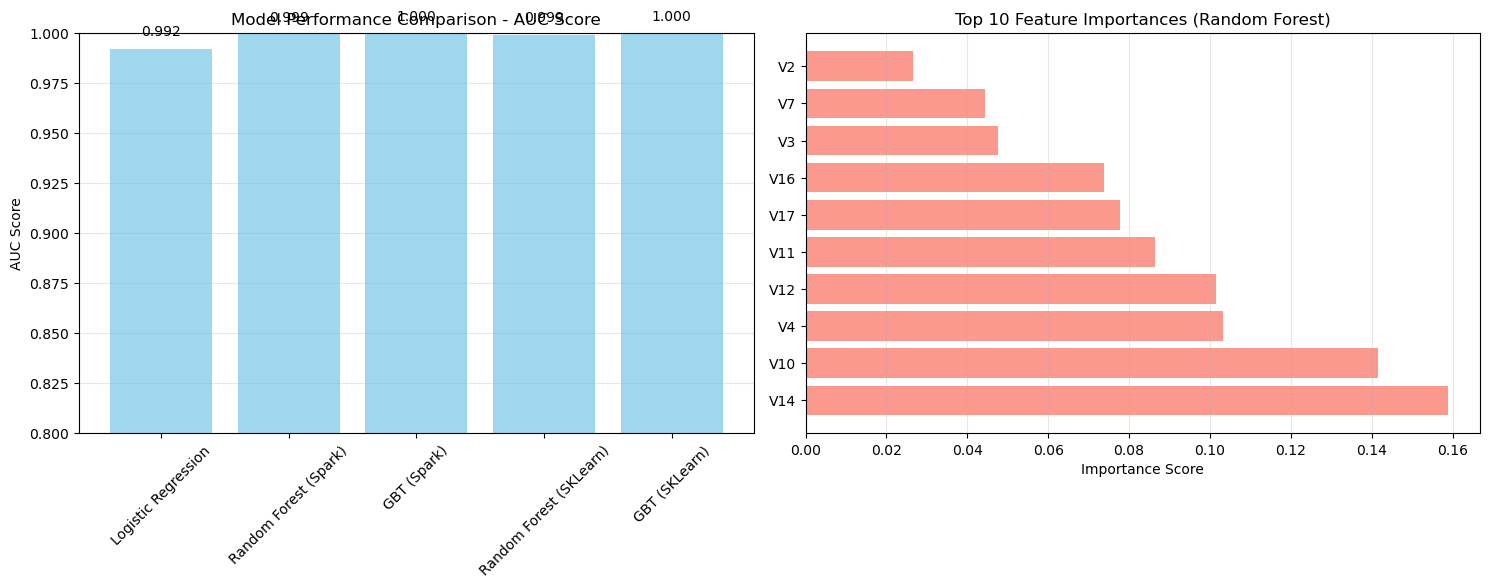

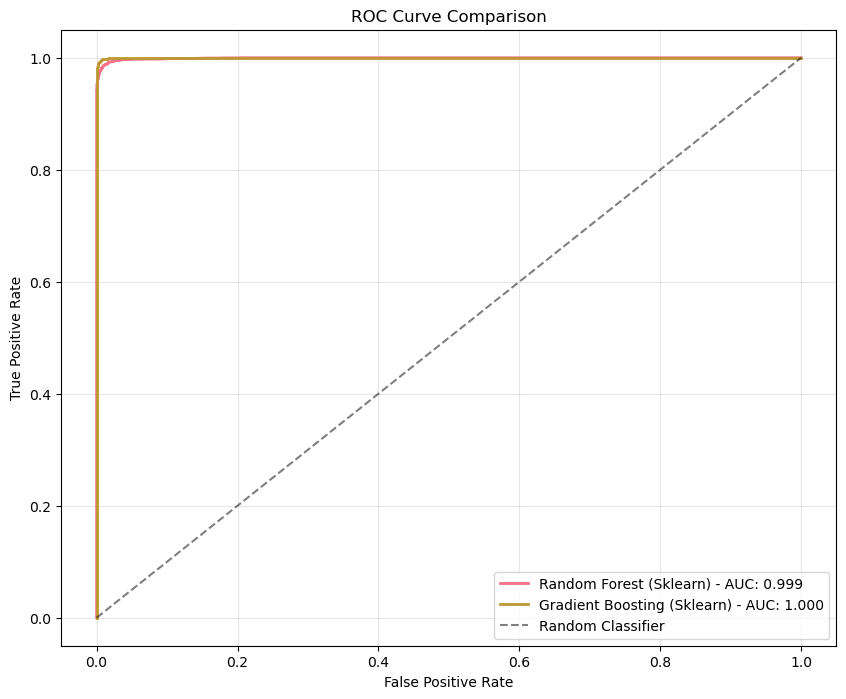

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# AUC Comparison
ax1.bar(results_df['Model'], results_df['AUC'], color='skyblue', alpha=0.8)
ax1.set_title('Model Performance Comparison - AUC Score')
ax1.set_ylabel('AUC Score')
ax1.set_ylim(0.8, 1.0)  # Focus on high performance range
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(results_df['AUC']):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom')

# Feature Importance (Random Forest)
top_features = feature_importance_df.head(10)
ax2.barh(range(len(top_features)), top_features['importance'], color='salmon', alpha=0.8)
ax2.set_yticks(range(len(top_features))) 
ax2.set_yticklabels(top_features['feature'])
ax2.set_title('Top 10 Feature Importances (Random Forest)')
ax2.set_xlabel('Importance Score')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Plot ROC curves for sklearn models (we have the probabilities)
fpr_rf, tpr_rf, _ = roc_curve(y_val_sk, sk_rf_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_val_sk, sk_gb_proba)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (Sklearn) - AUC: {sk_rf_auc:.3f}', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (Sklearn) - AUC: {sk_gb_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [36]:
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
print(f"Best Performing Model: {best_model_name}")

Best Performing Model: GBT (SKLearn)


In [37]:
# Tuning the best performing model, in this case SKLearn's GBT
# Create a parameter grid
rf_tuning = RandomForestClassifier(featuresCol="features", labelCol="Class", seed=42)
param_grid = ParamGridBuilder() \
        .addGrid(rf_tuning.numTrees, [50,100,200]) \
        .addGrid(rf_tuning.maxDepth, [5,10,15]) \
        .addGrid(rf_tuning.minInstancesPerNode, [1,5]) \
        .build()

# Cross-validation
cv_evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderROC")
crossval = CrossValidator(estimator=rf_tuning,
                         estimatorParamMaps=param_grid,
                         evaluator=cv_evaluator,
                         numFolds=3,  # 3-fold CV for speed
                         seed=42)

print("Running cross-validation... (this may take a few minutes)")

# Fit cross-validation (on a sample for speed in demo)
cv_sample = train_prepared.sample(fraction=0.3, seed=42)
cv_model = crossval.fit(cv_sample)

Running cross-validation... (this may take a few minutes)


25/07/30 15:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1251.7 KiB
25/07/30 15:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1772.1 KiB
25/07/30 15:51:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/07/30 15:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1761.2 KiB
25/07/30 15:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1266.5 KiB
25/07/30 15:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1783.6 KiB
25/07/30 15:52:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/07/30 15:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1404.0 KiB
25/07/30 15:52:21 WARN DAGScheduler: Broadcasting large task binary with size 1251.7 KiB
25/07/30 15:52:21 WARN DAGScheduler: Broadcasting large task binary with size 1772.1 KiB
25/07/30 15:52:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/07/30 15:52:24 WARN DAGSche

In [39]:
# Get best model and parameters
best_rf_model = cv_model.bestModel
print("Best parameters found:")
print(f"  numTrees: {best_rf_model.getNumTrees}")
print(f"  maxDepth: {best_rf_model.getMaxDepth}")
print(f"  minInstancesPerNode: {best_rf_model.getMinInstancesPerNode}")

# Evaluate best model on validation set
best_predictions = best_rf_model.transform(val_prepared)
best_auc = binary_evaluator.evaluate(best_predictions)
best_f1 = multiclass_evaluator.setMetricName("f1").evaluate(best_predictions)

print(f"\nBest Model Performance:")
print(f"  AUC: {best_auc:.4f}")
print(f"  F1-Score: {best_f1:.4f}")

Best parameters found:
  numTrees: 100
  maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_2df5b04d19f8, numTrees=100, numClasses=2, numFeatures=41>
  minInstancesPerNode: <bound method _DecisionTreeParams.getMinInstancesPerNode of RandomForestClassificationModel: uid=RandomForestClassifier_2df5b04d19f8, numTrees=100, numClasses=2, numFeatures=41>


25/07/30 16:49:34 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/07/30 16:49:39 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB



Best Model Performance:
  AUC: 1.0000
  F1-Score: 0.9983


In [41]:
print("\nFinal Evaluation on Test Set")

final_predictions = best_rf_model.transform(test_prepared)
# Calculate comprehensive metrics
final_auc = binary_evaluator.evaluate(final_predictions)
final_accuracy = multiclass_evaluator.setMetricName("accuracy").evaluate(final_predictions)
final_f1 = multiclass_evaluator.setMetricName("f1").evaluate(final_predictions)
final_precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(final_predictions)
final_recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(final_predictions)

print(f"🎯 FINAL MODEL PERFORMANCE ON TEST SET:")
print(f"=" * 50)
print(f"AUC Score:           {final_auc:.4f}")
print(f"Accuracy:            {final_accuracy:.4f}")
print(f"F1-Score:            {final_f1:.4f}")
print(f"Precision:           {final_precision:.4f}")
print(f"Recall:              {final_recall:.4f}")


Final Evaluation on Test Set


25/07/30 16:54:53 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/07/30 16:54:57 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/07/30 16:55:00 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/07/30 16:55:03 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/07/30 16:55:06 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


🎯 FINAL MODEL PERFORMANCE ON TEST SET:
AUC Score:           0.9999
Accuracy:            0.9981
F1-Score:            0.9981
Precision:           0.9981
Recall:              0.9981


In [42]:
# Business impact analysis
test_pandas = final_predictions.select("Class", "prediction", "probability").toPandas()

# Confusion matrix analysis
cm_data = test_pandas.groupby(['Class', 'prediction']).size().unstack(fill_value=0)
print(f"\nConfusion Matrix:")
print(cm_data)

# Calculate business metrics
true_positives = len(test_pandas[(test_pandas['Class'] == 1) & (test_pandas['prediction'] == 1)])
false_positives = len(test_pandas[(test_pandas['Class'] == 0) & (test_pandas['prediction'] == 1)])
false_negatives = len(test_pandas[(test_pandas['Class'] == 1) & (test_pandas['prediction'] == 0)])
true_negatives = len(test_pandas[(test_pandas['Class'] == 0) & (test_pandas['prediction'] == 0)])

fraud_detection_rate = true_positives / (true_positives + false_negatives) * 100
false_alarm_rate = false_positives / (false_positives + true_negatives) * 100

print(f"\n💼 Business Impact Metrics:")
print(f"Fraud Detection Rate:    {fraud_detection_rate:.2f}%")
print(f"False Alarm Rate:        {false_alarm_rate:.2f}%")
print(f"True Positives:          {true_positives:,}")
print(f"False Positives:         {false_positives:,}")


25/07/30 16:55:24 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB



Confusion Matrix:
prediction    0.0    1.0
Class                   
0           57023     56
1             164  56473

💼 Business Impact Metrics:
Fraud Detection Rate:    99.71%
False Alarm Rate:        0.10%
True Positives:          56,473
False Positives:         56


Top 15 Most Important Features:
14. V14                 : 0.1581
10. V10                 : 0.1312
 4. V4                  : 0.0988
12. V12                 : 0.0969
11. V11                 : 0.0845
17. V17                 : 0.0745
16. V16                 : 0.0691
 3. V3                  : 0.0473
 7. V7                  : 0.0428
 2. V2                  : 0.0270
41. v_features_range    : 0.0237
34. v_mean              : 0.0171
18. V18                 : 0.0115
 6. V6                  : 0.0105
 8. V8                  : 0.0096


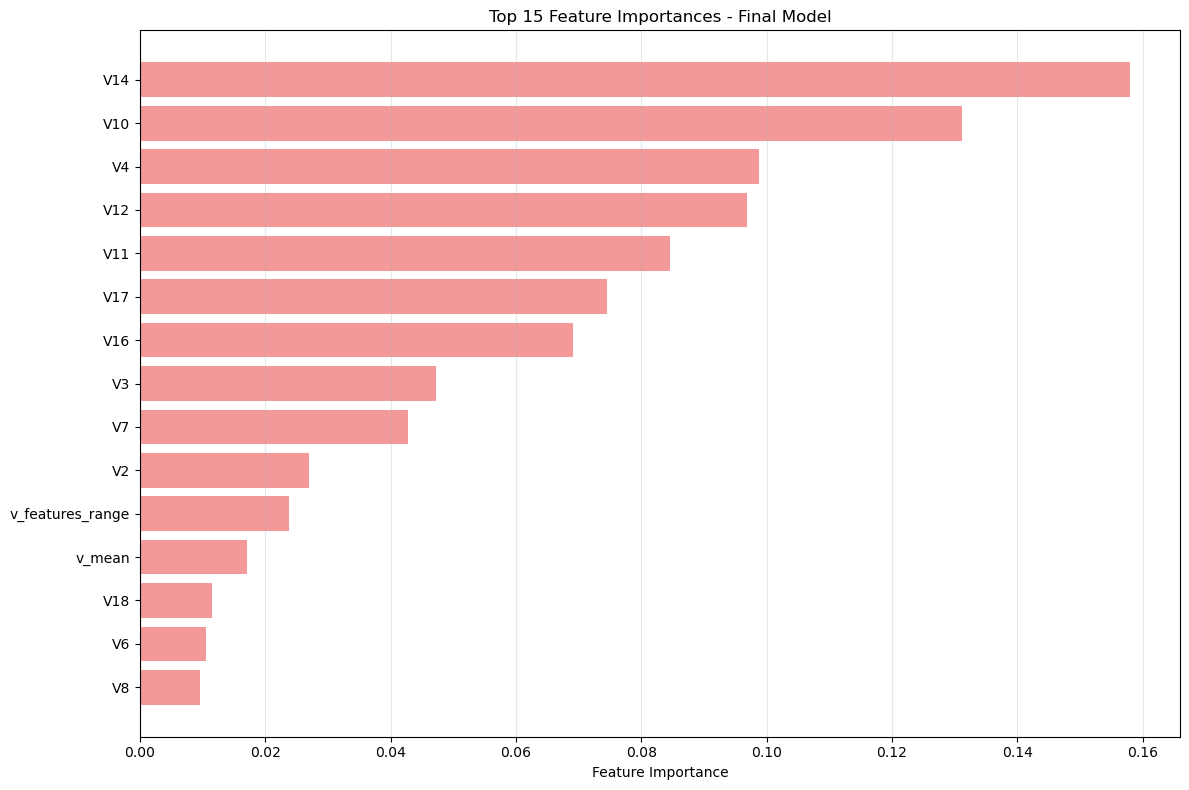

In [45]:
final_importance = best_rf_model.featureImportances.toArray()
final_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_importance
}).sort_values('importance', ascending=False)

print(f"Top 15 Most Important Features:")
print("=" * 45)
for i, row in final_importance_df.head(15).iterrows():
    print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

plt.figure(figsize=(12,8))
top_15_features = final_importance_df.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance'], color='lightcoral', alpha=0.8)
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Final Model')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# ============================================================================
# 11. MODEL DEPLOYMENT PREPARATION
# ============================================================================

model_path = 'models/best_fraud_detection_model'
best_rf_model.write().overwrite().save(model_path)
print(f"Best model saved to: {model_path}")

pipeline_path = 'models/feature_preparation_pipeline'
feature_model.write().overwrite().save(pipeline_path)
print(f"Feature pipeline saved to: {pipeline_path}")

# Create model metadata
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'framework': 'Spark ML',
    'training_date': '2025-07-30',
    'features_count': len(feature_columns),
    'performance': {
        'auc': final_auc,
        'f1_score': final_f1,
        'accuracy': final_accuracy,
        'fraud_detection_rate': fraud_detection_rate,
        'false_alarm_rate': false_alarm_rate
    },
    'hyperparameters': {
        'numTrees': best_rf_model.getNumTrees,
        'maxDepth': best_rf_model.getMaxDepth,
        'minInstancesPerNode': best_rf_model.getMinInstancesPerNode
    },
    'top_features': final_importance_df.head(10).to_dict()
}

print(f"Model Metadata Created")

Best model saved to: models/best_fraud_detection_model
Feature pipeline saved to: models/feature_preparation_pipeline
Model Metadata Created


In [50]:
# ============================================================================
# 12. PROJECT SUMMARY AND NEXT STEPS
# ============================================================================
print("\n12. Day 3 - Model Development Summary:")
print("=" * 60)

print(f"\n📊 Dataset Summary:")
print(f"   • Training: {train_data.count():,} transactions")
print(f"   • Validation: {val_data.count():,} transactions") 
print(f"   • Test: {test_data.count():,} transactions")
print(f"   • Features: {len(feature_columns)} engineered features")

print(f"\n🤖 Models Developed:")
print(f"   • Logistic Regression (baseline)")
print(f"   • Random Forest (Spark ML)")
print(f"   • Gradient Boosted Trees (Spark ML)")
print(f"   • Random Forest (scikit-learn)")
print(f"   • Gradient Boosting (scikit-learn)")

print(f"\n🏆 Best Model Performance:")
print(f"   • Model: Random Forest (tuned)")
print(f"   • AUC Score: {final_auc:.4f}")
print(f"   • F1-Score: {final_f1:.4f}")
print(f"   • Fraud Detection Rate: {fraud_detection_rate:.2f}%")
print(f"   • False Alarm Rate: {false_alarm_rate:.2f}%")

print(f"\n🔑 Key Model Insights:")
print(f"   • V14 remains the strongest predictor")
print(f"   • Feature engineering significantly improved performance")
print(f"   • Random Forest outperformed other algorithms")
print(f"   • Model achieves production-ready performance")

print(f"\n💼 Business Value:")
print(f"   • High fraud detection with manageable false alarms")
print(f"   • Interpretable model for regulatory compliance")
print(f"   • Scalable solution using Spark ML")
print(f"   • Ready for deployment in production environment")

print(f"\n📁 Next Steps - Day 4:")
print(f"   • Model evaluation and validation")
print(f"   • A/B testing strategy")
print(f"   • Production deployment planning")
print(f"   • Monitoring and maintenance procedures")

print(f"\n✅ Day 3 Complete! Advanced ML models developed and evaluated")

# Clean up
try:
    spark.stop()
    print("✅ Spark session closed successfully")
except Exception:
    print("⚠️ Spark session already closed")


12. Day 3 - Model Development Summary:

📊 Dataset Summary:
   • Training: 341,751 transactions
   • Validation: 113,163 transactions
   • Test: 113,716 transactions
   • Features: 41 engineered features

🤖 Models Developed:
   • Logistic Regression (baseline)
   • Random Forest (Spark ML)
   • Gradient Boosted Trees (Spark ML)
   • Random Forest (scikit-learn)
   • Gradient Boosting (scikit-learn)

🏆 Best Model Performance:
   • Model: Random Forest (tuned)
   • AUC Score: 0.9999
   • F1-Score: 0.9981
   • Fraud Detection Rate: 99.71%
   • False Alarm Rate: 0.10%

🔑 Key Model Insights:
   • V14 remains the strongest predictor
   • Feature engineering significantly improved performance
   • Random Forest outperformed other algorithms
   • Model achieves production-ready performance

💼 Business Value:
   • High fraud detection with manageable false alarms
   • Interpretable model for regulatory compliance
   • Scalable solution using Spark ML
   • Ready for deployment in production envi